# Data Cleaning, Feature Engineering, Initial EDA Notebook

In [80]:
# Standard imports
import numpy as np
import pandas as pd
from copy import copy

# Scikit-learn for scaling
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# Data visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Export data
import pickle

# Scotus class object
from scotus_class import scotus

In [2]:
df = pd.read_csv('scotus_rulings.csv', index_col=0)

## Clean data and engineer metric
There are 2 ways shown below on how the case features maybe be engineered/cleaned.  The first treats a case as either a vote with the majority or a dissent.  The second maintains the level of concurrence/dissent of a justice.  In each case, a justice can hold multiple opinions.  They can simultaneously agree with the decision of the majority opinion but hold a separate reasoning(s) on the ruling (filing a concurrence).  With 1 being agreement and 2 filing a concurrence (and similarly 4 being dissent and 3 filing a concurrence/dissent).  The metric used here tries to capture the difference between those opinions by finding the mean of a justice's opinion (while removing filing multiple concurrences/dissents in a specific case).

In [13]:
# Map code string to metric function (binary)
def string_2_ints(s):    
    # Special case 'X' is no vote
    if s is np.nan:
        return np.nan
    if s == 'X':
        return np.nan
    
    # Split and remove non-integers and simplify to either majority or dissent
    nums = []
    for x in set(list(s)):
        try:
            if int(x) > 2: # Any dissent is assigned as dissent against majority opinion
                nums.append(1)
            elif int(x) <= 2:
                nums.append(0)
            elif str(x) == 'nan':
                continue
        except:
            continue

    return nums[0]

# Map code string to metric function (multi-class)
def string_2_multi(s):    
    # Special case 'X' is no vote
    if s is np.nan:
        return np.nan
    if s == 'X':
        return np.nan
    
    # Split and remove non-integers
    nums = []
    for x in set(list(s)):
        try:
            nums.append(int(x)-1)
        except:
            continue
            
    # Return floor of mean value of justices' opinions
    return np.floor(np.mean(nums))

In [14]:
adj_df = pd.DataFrame(np.vectorize(string_2_ints)(df), index=df.index)
mul_df = pd.DataFrame(np.vectorize(string_2_multi)(df), index=df.index)

In [15]:
adj_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1638,1639,1640,1641,1642,1643,1644,1645,1646,1647
Alito,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Breyer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
Ginsburg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [16]:
mul_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1638,1639,1640,1641,1642,1643,1644,1645,1646,1647
Alito,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Breyer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0,3.0,3.0
Ginsburg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0,3.0,0.0


In [17]:
# Pickle for prediction models
f = open('adj_df.p', 'wb')
pickle.dump(adj_df, f)
f.close()

f = open('mul_df.p', 'wb')
pickle.dump(mul_df, f)
f.close()

## Scotus Rulings Class Object
A class object was created in order to encapsulate data in the file ```scotus_class.py```.  The methods return various forms of data including courts of justices (as old ones retire and new ones are appointed) allowing for easy comparisons for EDA and in a dashboard.

In [18]:
scotus_obj = scotus(adj_df)
scotus_mul = scotus(mul_df)

## Initial EDA

### Mean Level of Dissent
There are 2 different coding frameworks used here.  The first is a binary framework where justice opinions are either coded as agree with majority or disagree with majority.  The second is a discreet multiclass framework where justice opinions are coded as varying levels of agreement or disagreement.

Justice's opinions on cases (binary):
- 0 = Agreed with Majority Opinion
- 1 = Disagreed with Majority Opinion

Justice's opinions on cases (multiclass):
- 0 = Wrote or Joined Majority
- 1 = Wrote or Joined a Concurrence
- 2 = Wrote or Joined a Concurrence/Dissent
- 3 = Wrote or Joined a Dissent

The graph below illustrates the mean opinion of a justice.  A greater mean opinion equates to a greater tendency to have a differing opinion than the majority opinion.

In [19]:
fig = make_subplots(rows=2, cols=1)

justices = adj_df.index
j_mean_bin = pd.DataFrame(adj_df.mean(axis=1)).reset_index()[0]
j_mean_mul = pd.DataFrame(mul_df.mean(axis=1)).reset_index()[0]

fig.add_trace(go.Bar(x=justices, y=j_mean_bin, name='Binary'), row=1, col=1)
fig.add_trace(go.Bar(x=justices, y=j_mean_mul, name='Multiclass'), row=2, col=1)

fig.update_xaxes(categoryorder='total descending')
fig.update_layout(title='Justices by Mean Opinion')

### Similarity Matrix
The plot below illustrates the cosine similarity and Pearson's correlation between justices

In [81]:
sim_mat = pd.DataFrame(scotus_obj.sim_matrix(), index=adj_df.index, columns=adj_df.index)
sim_mul = pd.DataFrame(scotus_mul.sim_matrix(), index=mul_df.index, columns=mul_df.index)

In [82]:
# Build matrices for heatmap
a = copy(sim_mat)
b = copy(sim_mul)
mask = np.zeros(sim_mat.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
a[mask] = np.nan
b[mask] = np.nan
c = a.drop(columns='Thomas').drop('Alito')
d = b.drop(columns='Thomas').drop('Alito')
z1 = np.array(c)
z2 = np.array(d)

# Similarity heatmaps
fig = make_subplots(rows=2, cols=1, subplot_titles=['Binary', 'Multiclass'])
fig.add_trace(go.Heatmap(z=z1, x=c.columns, y=c.index, colorscale='RdBu', zmin=0, zmax=1), row=1, col=1)
fig.add_trace(go.Heatmap(z=z2, x=d.columns, y=d.index, colorscale='RdBu', zmin=0, zmax=1, showscale=False), row=2, col=1)
fig.update_layout(height=800, width=800, template='simple_white', title='Cosine Similarity')
fig.show()

In [83]:
# Build matrices for heatmap
a = copy(adj_df.T.corr())
b = copy(mul_df.T.corr())
mask = np.zeros(sim_mat.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
a[mask] = np.nan
b[mask] = np.nan
c = a.drop(columns='Thomas').drop('Alito')
d = b.drop(columns='Thomas').drop('Alito')
z1 = np.array(c)
z2 = np.array(d)

# Similarity heatmaps
fig = make_subplots(rows=2, cols=1, subplot_titles=['Binary', 'Multiclass'])
fig.add_trace(go.Heatmap(z=z1, x=c.columns, y=c.index, colorscale='RdBu', zmin=-1, zmax=1), row=1, col=1)
fig.add_trace(go.Heatmap(z=z2, x=d.columns, y=d.index, colorscale='RdBu', zmin=-1, zmax=1, showscale=False), row=2, col=1)
fig.update_layout(height=800, width=800, template='simple_white', title='Pearson Correlation')
fig.show()

### Cosine Similarity as a Network Graph

In [85]:
# Create nodes
nodes = scotus_mul.justices
l = len(nodes)

In [86]:
# Scale data
scaler = MinMaxScaler()
new_df = pd.DataFrame(scaler.fit_transform(sim_mul), index=sim_mul.index, columns=sim_mul.columns)

In [87]:
# Create edges, tuple = (justice A, justice B, cosine similarity)
edges = []
for i in range(l):
    for j in range(i+1, l):
        if str(new_df.iloc[i][j]) != 'nan':
            tup = (new_df.iloc[i].name, new_df.iloc[i].index[j], new_df.iloc[i][j])
            edges.append(tup)

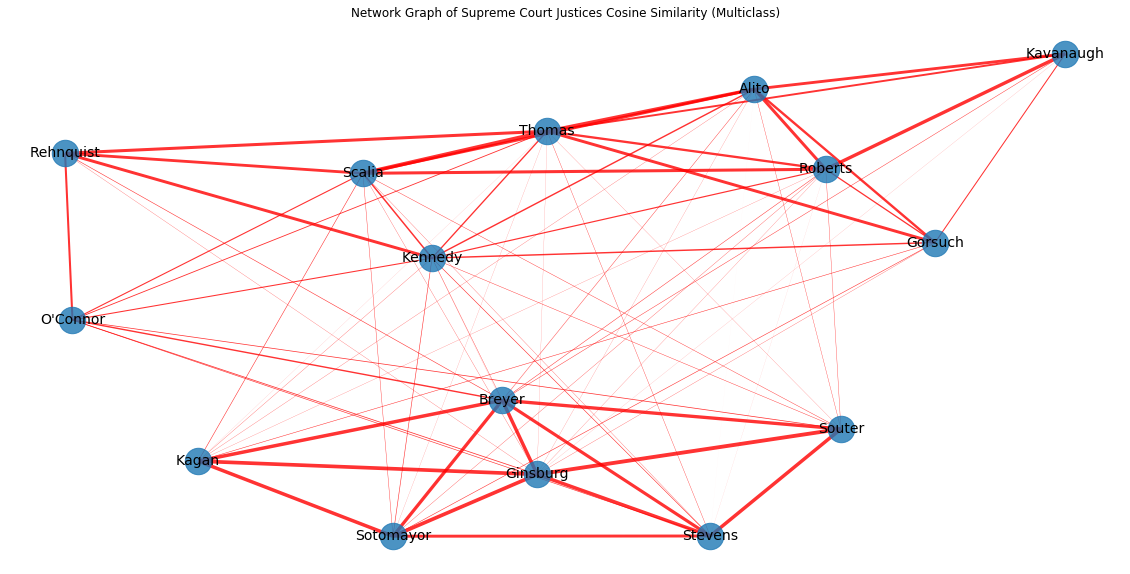

In [92]:
# Instantiate graph object
fig = plt.figure(figsize=(20,10))
G = nx.Graph()

# Add edges to graph
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

# Positions of nodes and edges
pos = nx.spring_layout(G)

# Plot Nodes
nx.draw_networkx_nodes(G, pos, node_size=700, alpha=0.8)

# Plot individually weighted edges
for (u, v, d) in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=d['weight']*5, edge_color='r', alpha=0.8)

# Add Justice Labels
nx.draw_networkx_labels(G, pos, font_size=14, font_family='sans-serif')

plt.axis('off')
plt.title('Network Graph of Supreme Court Justices Cosine Similarity (Multiclass)')
plt.show()